In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
import numpy as np
import sympy as sy
from sympy import symbols
from scipy import interpolate
from scipy import optimize
import matplotlib
from matplotlib import pyplot as plt
import ngfunction

In [2]:
##PARAMETRI INIZIALI

pars = camb.CAMBparams()  #0.022 0.122 67.5
pars.set_cosmology(H0=73, ombh2=0.023, omch2=0.111)   #H0= hubble parameter today in km/s    ombh2=physical density in baryons omch2=physical density in cold dark matter
#trovo densità diverse...
pars.InitPower.set_params(ns=0.965)  #ns = scalar spectra index (inflaction)


class: <InitialPowerLaw>
 tensor_parameterization = tensor_param_rpivot
 ns = 0.965
 nrun = 0.0
 nrunrun = 0.0
 nt = -0.0
 ntrun = -0.0
 r = 0.0
 pivot_scalar = 0.05
 pivot_tensor = 0.05
 As = 2e-09
 At = 1.0
 

In [3]:
pars.set_matter_power(redshifts=[1.4], kmax=3.0)  
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)   

In [4]:
kh, z, pk = results.get_matter_power_spectrum(minkh=2e-2, maxkh=1e-1, npoints = 100) #nota, le z vengono ordinate, ricavo spettro di potenza

In [5]:
#Parametri cosmolgici
def dist(z):   #funzione per trasformare il redshift in distanza
    return results.comoving_radial_distance(z) #coefficiente per trasformare il redshift in un raggio, c/H0 = [km/s  / (km/s)/Mpc] = [Mpc], z è adimensionale

H0 = results.hubble_parameter(0)    #parametri di hubble
h = H0/100
def H(z):
    return results.hubble_parameter(z)

kh = kh/h  #H0 = 70km/(s*Mpc) h=0.7 ma non era senza unità di misura?
pk = pk*h**3

In [71]:
#Funzioni varie
bias = 1 + z[0]*0.84   #funzione di bias delle galassie, cercane altre!!
f = (results.get_fsigma8()/results.get_sigma8())
 #la calcola alla z scelta già, UNITà DI MISURA

mu = np.arange(-1,1,0.1)      #range di valori dell'angolo
N = len(kh)*len(mu)   #numero di dati simulati


-2.220446049250313e-16

In [7]:
#Set di dati simulati spettro di potenza delle galassie
Pgg = np.empty((len(kh),len(mu)))
for i in range (len(kh)):
    for j in range (len(mu)):
        Pgg[i][j] = ( float(np.power(bias + f * np.power(mu[j],2),2)*pk[:,i]))


In [8]:
#Dati per la funzione teorica
om = results.get_Omega('cdm',0) + results.get_Omega('baryon',0)    #densità di materia nell'universo
omz= om*(1+z[0])**3/(H(z[0])/H0)**2 #densità di materia a diverso z
omz

0.819379708157461

In [9]:
#Confronto preliminare
print(f)
print(omz**0.545)

[0.90074543]
0.8971177229812607


In [10]:
##Errori dei dati simulati
ng= ngfunction.Ng(z[0])*10**4/h**3   #mean galaxy number density for z near 0 (Euclid spettroscopy survey)
DeltaMu = np.abs(mu[0]-mu[1])
DeltaZ = 0.1
DeltaK = np.empty((len(kh)))

for i in range (len (kh)):
    if i==0 : DeltaK[i]= 2*np.abs(kh[i+1]-kh[i])
    elif i==len(kh)-1:
       DeltaK[i]= 2*np.abs(kh[i-1]-kh[i])
    else: DeltaK[i]= np.abs(kh[i+1]-kh[i])/2+ np.abs(kh[i-1]-kh[i])/2
    if(DeltaK[i]<1e-2): DeltaK[i]=1e-2   #l'intervallo deve comunque essere più grande di kmin, se non lo è lo metto uguale a kmin
    
N = np.empty((len(kh),len(mu)))
Vol = 4./3.*np.pi*((dist(z[0]+DeltaZ/2))**3-(dist(z[0]-DeltaZ/2)**3))    #calcolo il volume di cielo considerato, inmmagino di guardare il cielo su tutti gli angoli (ideale)

for j in range(len(kh)):
    N[j,:]= Vol/(2*np.pi)**3 * kh[j]**2*DeltaMu*DeltaK[j]  #uguale per tutte le mu

err_Pgg = np.empty((len(kh),len(mu)))
for i in range (len(kh)):
    for j in range (len(mu)):
        err_Pgg[i][j] = np.sqrt(2/N[i][j])*(Pgg[i][j]+1/ng)




In [11]:
#cerco la distanza minima, per risalire il kmin da mettere all'inizio del codice

kmin= 2*np.pi/(dist(z[0]+DeltaZ/2)-dist(z[0]-DeltaZ/2))
kmin*h

0.023000771065095533

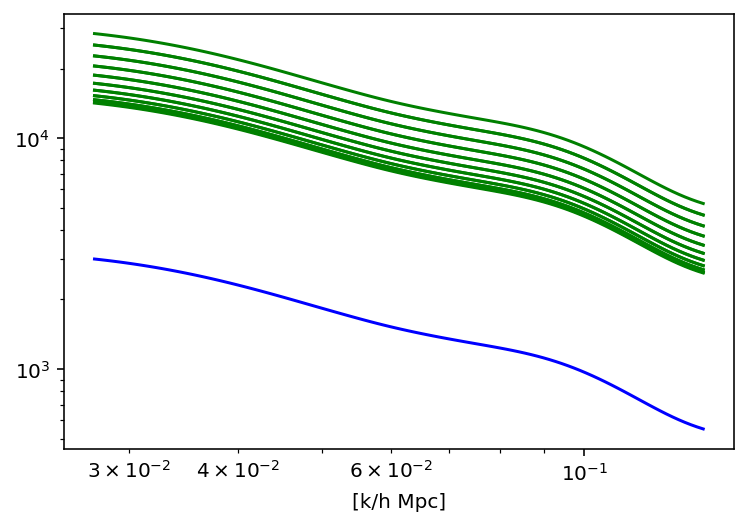

In [12]:
#Grafico

fit, ax = plt.subplots()

ax.set_xlabel('[k/h Mpc]')
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(kh, pk[0,:], color='b', ls = '-')
for i in range(len(mu)):
    ax.plot(kh, Pgg[:,i], color='g', ls ='-')  #aggiungi gli errori

#ax.legend(['matter','galaxy'], loc='lower left')
#plt.title('Total Matter power at z=%s and z= %s'%tuple(z));

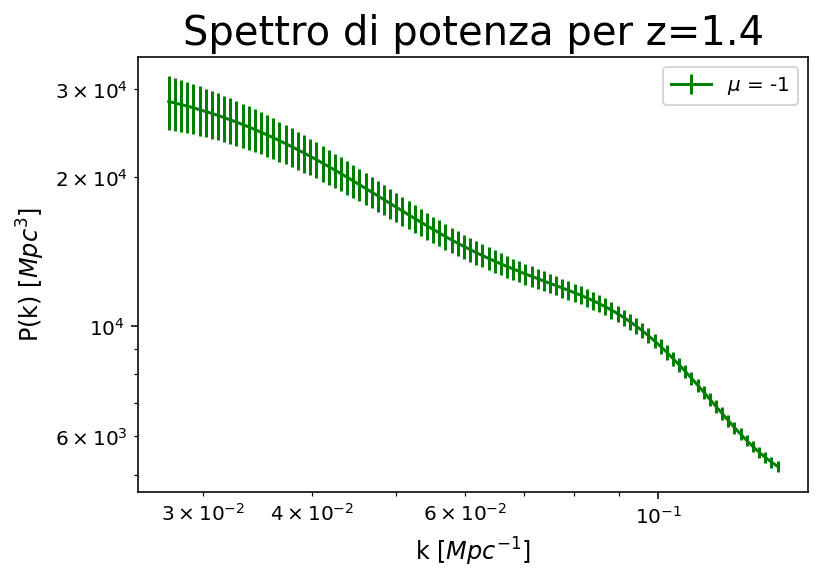

In [77]:
#Grafico con errori
fit, ax = plt.subplots()

ax.set_ylabel('P(k) [$Mpc^3$]',size = 12)
ax.set_xlabel('k [$Mpc^{-1}$]', size = 12)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Spettro di potenza per z=1.4', size = 20)

ax.errorbar(kh, Pgg[:,0], yerr = err_Pgg[:,0], color='g', ls ='-', label = '$\mu$ = -1')  #aggiungi gli errori
ax.legend()


In [47]:
#calcolo il chi quadro per un certo set di valori di gamma

gammas= np.arange(0.45,0.6,0.001)   
for k in range(len(gammas)):
    gammas[k] = round (gammas[k],3)

chi2 = np.zeros(len(gammas))


for k,gamma in enumerate(gammas):
    for i in range (len(kh)):
        for j in range (len(mu)):
            chi2[k]= chi2[k]+(float((bias + (omz**gamma) * (mu[j])**2)**2*pk[:,i]) - Pgg[i][j])**2/err_Pgg[i][j]**2
        



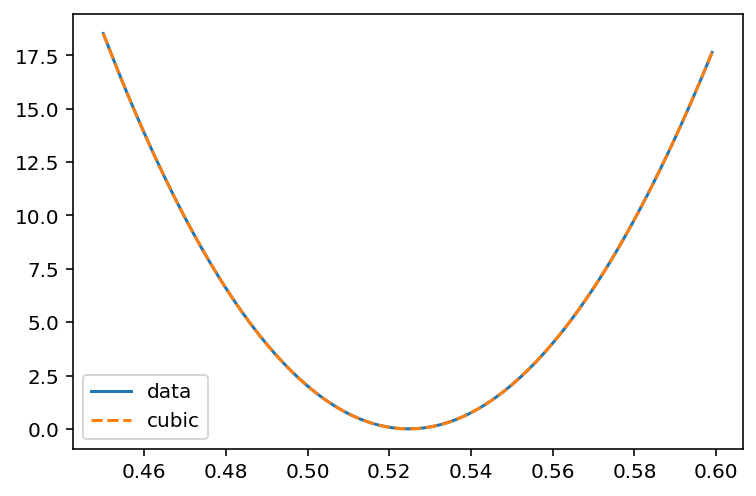

In [48]:
#INTERPOLAZIONE FUNZIONE CHI^2
interpol =  interpolate.interp1d(gammas,chi2,kind='cubic')
plt.plot(gammas,chi2,'-', gammas, interpol(gammas), '--')
plt.legend(['data', 'cubic'])


#plt.axis([0.54,0.56,0,0.4e9])

In [49]:
type(interpol)
y=lambda x: interpol(x)


In [50]:
#calcolo del minimo
minimo = optimize.least_squares(y,0.5)
min1= float(minimo.x)
chi2min= y(min1)
minimo

 active_mask: array([0.])
        cost: 7.19913917802854e-15
         fun: array([1.19992826e-07])
        grad: array([-4.73884418e-09])
         jac: array([[-0.03949273]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 13
        njev: 13
  optimality: 4.738844176327756e-09
      status: 1
     success: True
           x: array([0.52473574])

In [51]:
min2= np.min(chi2)      #trova un valore minimo di chi2, solo a livello discreto, meno preciso
index_min = np.argmin(chi2)
gamma_min = gammas[index_min]
gamma_min

0.525

In [52]:
min(gammas)

0.45

Text(0, 0.5, '$\\Delta \\chi^2$')

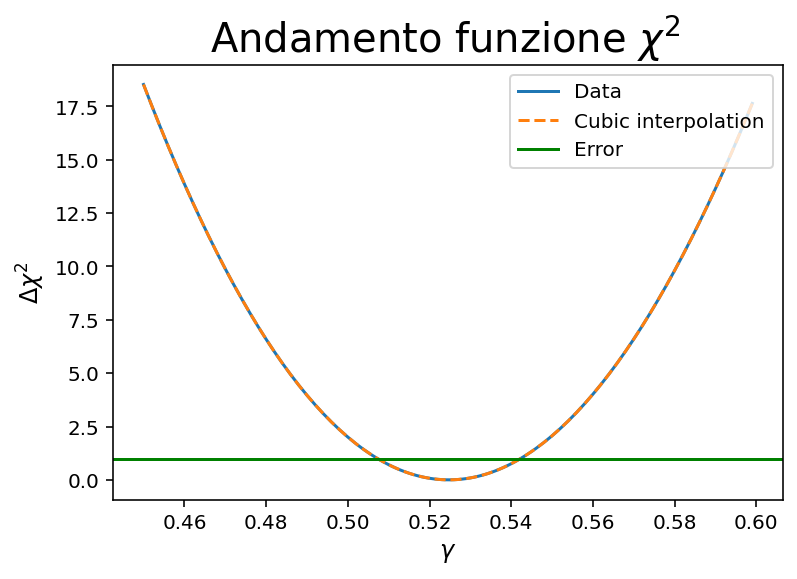

In [62]:
#devo scalare il grafico
plt.plot(gammas,chi2-chi2min,'-', gammas, interpol(gammas)-chi2min, '--')

#CALCOLO DELL'ERRORE
plt.axhline(y=1,  color = 'g')

plt.legend(['Data', 'Cubic interpolation','Error'], loc = 'upper right')

plt.title('Andamento funzione $\chi ^2$ ', size=20)
plt.xlabel('$\gamma$', size = 12)
plt.ylabel('$\Delta \chi^2$', size = 12)



In [20]:
#calcolo intersezioni con y=1 per gli erori
y2= lambda x: interpol(x) - 1 -chi2min
intersec1 = optimize.brentq(y2,0.45,min1)    #trova le soluzioni in un intervallo fissato
intersec2 = optimize.brentq(y2,min1,0.57)
print(intersec1,intersec2)

0.5072576923874664 0.5423004357223844


In [21]:
err1=(np.abs(min1-intersec1))
err2=(np.abs(min1-intersec2))

print(err1,err2)

sigma = round(err1,3)
print(sigma)

0.01747805217801157 0.017564691156906398
0.017


In [22]:
print("Il valore di gamma trovato è: ", round(min1,3) ," +- ", sigma)

Il valore di gamma trovato è:  0.525  +-  0.017


In [23]:
##ULTERIORE TEST SUL CHI2
chi2_ = np.zeros(len(gammas))

for k,gamma in enumerate(gammas):
    for i in range (len(kh)):
        for j in range (len(mu)):
            chi2_[k]= chi2_[k]+(float((bias + f* (mu[j])**2)**2*pk[:,i]) - Pgg[i][j])**2/err_Pgg[i][j]**2

In [24]:
min2_= np.min(chi2_)      #trova un valore minimo di chi2, solo a livello discreto, meno preciso
index_min_ = np.argmin(chi2_)
gamma_min_ = gammas[index_min_]
min2_

0.0